# Multi-label Emotion Detection

SemEval2025 Task 11 Track A + C

Finetune model to generate code
use our data to fine-tune and evaluate
Evaluate fine-tuned vs zero-shot vs baseline (generate n times and record error rate)
Use a dataset for training

## 1A. Environment Set-up 

In [6]:
# Environment check 
import os
assert os.environ['CONDA_DEFAULT_ENV'] == "cs375"

import sys
assert sys.version_info.major == 3 and sys.version_info.minor == 11

#### Installing other packages

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# set a seed value
torch.manual_seed(69)

import sentencepiece
#possibly remove some metrics later
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import transformers

#Choose between Bert and XLM Roberta
#from transformers import BertTokenizer, BertForSequenceClassification 
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import warnings
warnings.filterwarnings("ignore")

## 1B. Data exploration

In [8]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def split_data(data, test_size=0.2, random_state=42):
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=random_state)
    return train_data, val_data

# Custom Dataset class
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["text"]
        labels = self.data.iloc[index][["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values.astype(float)

        # Tokenize text
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(labels, dtype=torch.float),
        }

In [9]:
#Initialize tokenizer and model
def initialize_model_and_tokenizer():
    #USE FOR XLM ROBERTA
    #MODEL_TYPE = 'xlm-roberta-base'
    #tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_TYPE)
    #model = XLMRobertaForSequenceClassification.from_pretrained(
       # MODEL_TYPE, num_labels = 5
    #)

    #USE FOR DISTILBERT (not currently in use, need to uncomment autotokenizer in 1A too)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-multilingual-cased", num_labels=5
    )
    return tokenizer, model

    #USE FOR BERT
    #tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
    #model = BertForSequenceClassification.from_pretrained(
        #'bert-base-multilingual-cased', 
        #num_labels = 5,
        #output_attentions = False,
        #output_hidden_states = False
    #)
    return tokenizer, model

def train_model(model, train_loader, val_loader, device, epochs=3, learning_rate=5e-5):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )

            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

        evaluate_model(model, val_loader, device)

# Evaluation function
def evaluate_model(model, val_loader, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            preds = torch.sigmoid(outputs.logits)
            preds = (preds > 0.5).float()

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    
    emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
    for i, emotion in enumerate(emotion_labels):
        cm = confusion_matrix(true_labels[:, i], pred_labels[:, i])
        print(f"Confusion Matrix for {emotion}:")
        print(cm)
        
        #visualizing confusion matrix for our error anaylsis
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix for {emotion}")
        plt.show()
    
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=emotion_labels))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training Loss: 0.5630
Confusion Matrix for Anger:
[[493   0]
 [ 61   0]]


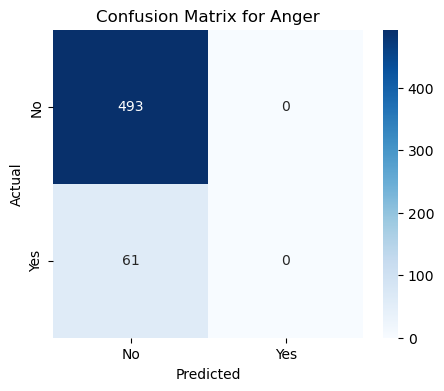

Confusion Matrix for Fear:
[[107 133]
 [ 61 253]]


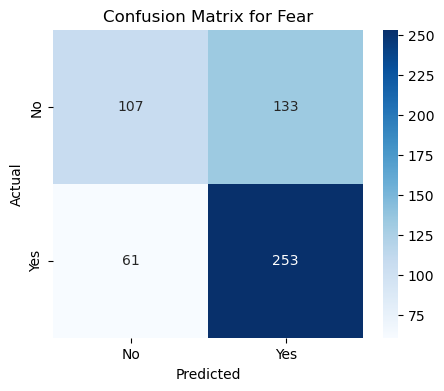

Confusion Matrix for Joy:
[[420   0]
 [134   0]]


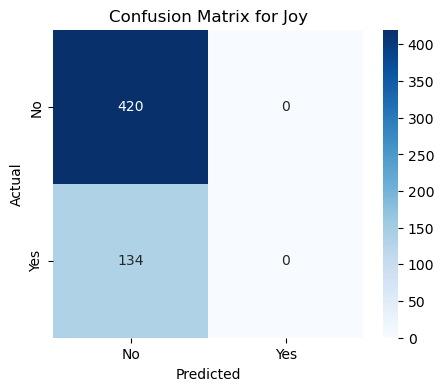

Confusion Matrix for Sadness:
[[383   0]
 [171   0]]


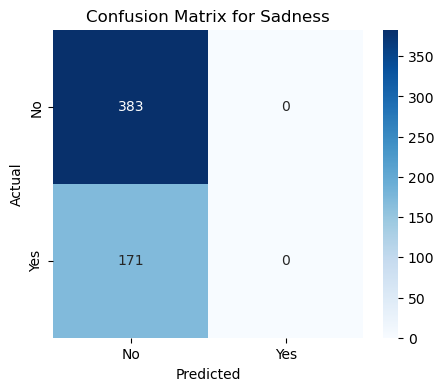

Confusion Matrix for Surprise:
[[359  23]
 [117  55]]


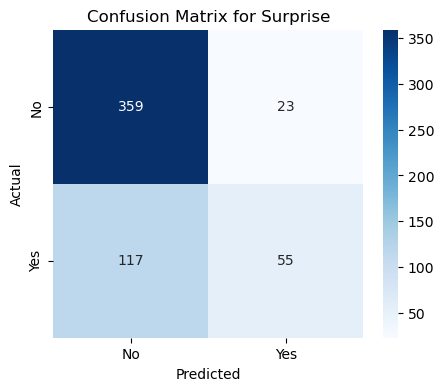

Classification Report:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        61
        Fear       0.66      0.81      0.72       314
         Joy       0.00      0.00      0.00       134
     Sadness       0.00      0.00      0.00       171
    Surprise       0.71      0.32      0.44       172

   micro avg       0.66      0.36      0.47       852
   macro avg       0.27      0.23      0.23       852
weighted avg       0.38      0.36      0.36       852
 samples avg       0.49      0.32      0.37       852

Epoch 2, Training Loss: 0.4913
Confusion Matrix for Anger:
[[493   0]
 [ 61   0]]


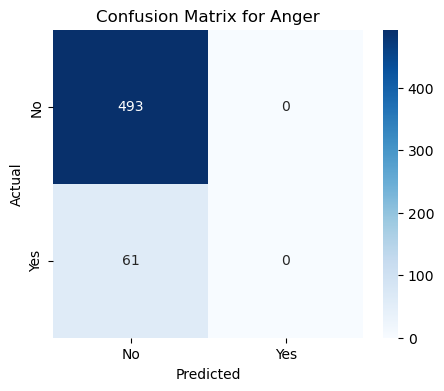

Confusion Matrix for Fear:
[[ 86 154]
 [ 32 282]]


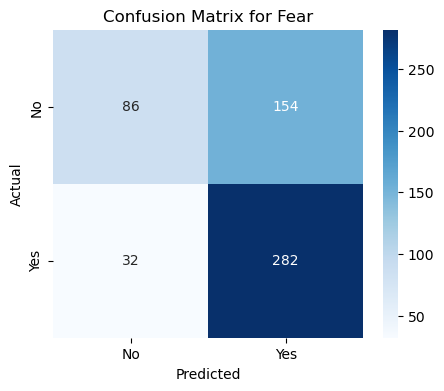

Confusion Matrix for Joy:
[[409  11]
 [105  29]]


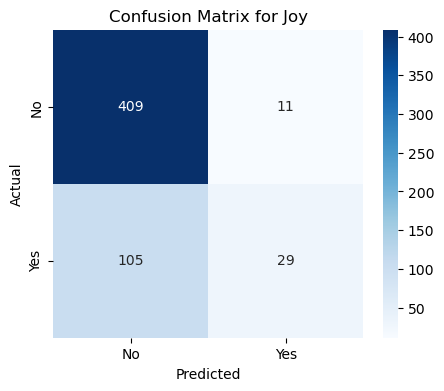

Confusion Matrix for Sadness:
[[303  80]
 [ 76  95]]


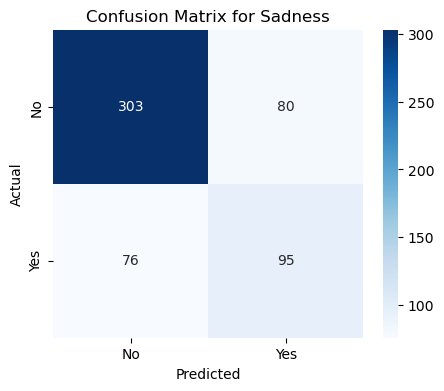

Confusion Matrix for Surprise:
[[325  57]
 [ 74  98]]


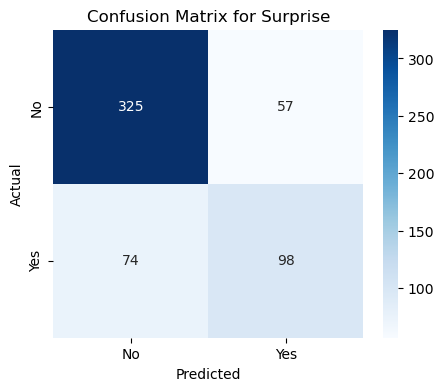

Classification Report:
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        61
        Fear       0.65      0.90      0.75       314
         Joy       0.72      0.22      0.33       134
     Sadness       0.54      0.56      0.55       171
    Surprise       0.63      0.57      0.60       172

   micro avg       0.63      0.59      0.61       852
   macro avg       0.51      0.45      0.45       852
weighted avg       0.59      0.59      0.56       852
 samples avg       0.56      0.52      0.52       852

Epoch 3, Training Loss: 0.3720
Confusion Matrix for Anger:
[[478  15]
 [ 49  12]]


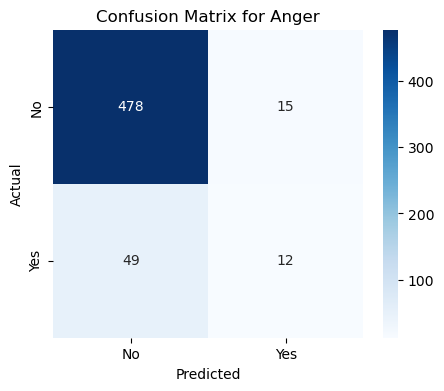

Confusion Matrix for Fear:
[[ 84 156]
 [ 22 292]]


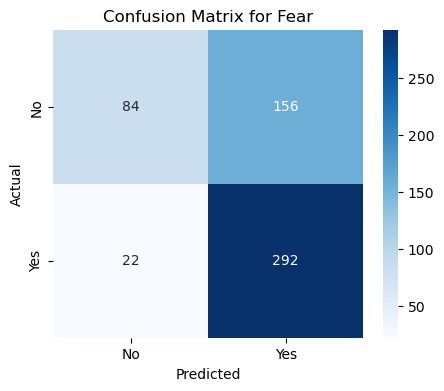

Confusion Matrix for Joy:
[[408  12]
 [107  27]]


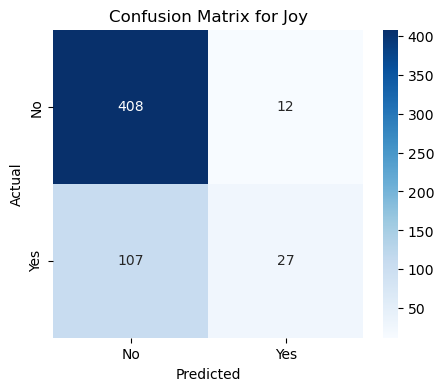

Confusion Matrix for Sadness:
[[261 122]
 [ 66 105]]


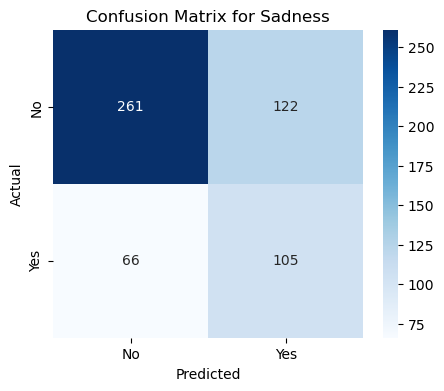

Confusion Matrix for Surprise:
[[336  46]
 [ 94  78]]


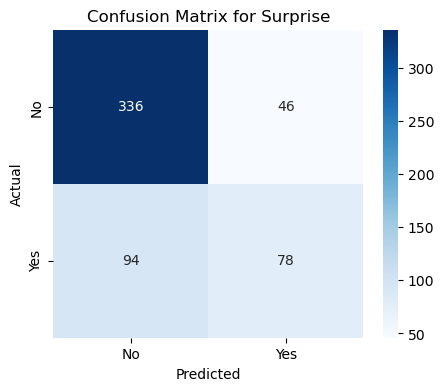

Classification Report:
              precision    recall  f1-score   support

       Anger       0.44      0.20      0.27        61
        Fear       0.65      0.93      0.77       314
         Joy       0.69      0.20      0.31       134
     Sadness       0.46      0.61      0.53       171
    Surprise       0.63      0.45      0.53       172

   micro avg       0.59      0.60      0.60       852
   macro avg       0.58      0.48      0.48       852
weighted avg       0.60      0.60      0.56       852
 samples avg       0.55      0.53      0.51       852



In [ ]:
dataset_file_path = "public_data/train/track_a/eng.csv"  # Your complete dataset file
batch_size = 16
max_length = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
data = load_data(dataset_file_path)

# Split the dataset into training and validation sets (80/20 split)
train_data, val_data = split_data(data, test_size=0.2)
#train_data = train_data.sample(n=100, random_state=42)
#val_data = val_data.sample(n=20, random_state=42)

# Initialize tokenizer and model
tokenizer, model = initialize_model_and_tokenizer()

# Create datasets and data loaders
train_dataset = EmotionDataset(train_data, tokenizer, max_length)
val_dataset = EmotionDataset(val_data, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train and evaluate the model
train_model(model, train_loader, val_loader, device, epochs=3)